In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df_fe = pd.read_csv("data/processed/transactions_features.csv")
df_fe.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_balance_ratio,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_diff,dest_balance_diff,zero_balance_after,large_amount_flag
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.057834,False,False,True,False,9839.64,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.087731,False,False,True,False,1864.28,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0.994505,False,False,False,True,181.00,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.994505,True,False,False,False,181.00,-21182.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.280788,False,False,True,False,11668.14,0.0,0,0


In [2]:
df_fe = df_fe.sort_values("step").reset_index(drop=True)

X = df_fe.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_fe['isFraud']

split_idx = int(0.8 * len(df_fe))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [3]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


isFraud
0    0.996657
1    0.003343
Name: proportion, dtype: float64

### MODEL DEVELOPMENT

In [4]:
X_train.shape, X_test.shape


((5090096, 15), (1272524, 15))

In [5]:
y_train.value_counts(normalize=True)


isFraud
0    0.999222
1    0.000778
Name: proportion, dtype: float64

### Baseline Model: Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

lr.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [7]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1268270
           1       0.14      0.89      0.25      4254

    accuracy                           0.98   1272524
   macro avg       0.57      0.94      0.62   1272524
weighted avg       1.00      0.98      0.99   1272524

ROC-AUC: 0.9909157041360485


### Train Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

### Evaluate Random Forest

In [10]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1268270
           1       1.00      1.00      1.00      4254

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 1.0


### ROC Curve Comparison

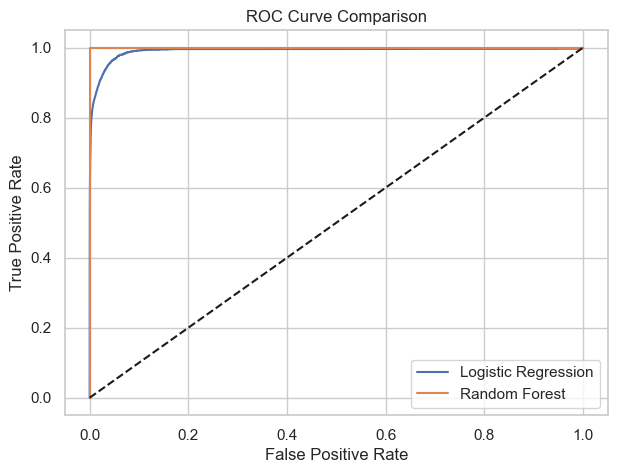

In [12]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


### Confusion Matrix

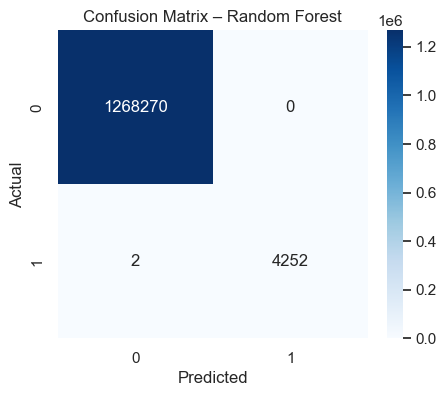

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()


### Precision–Recall Trade-off

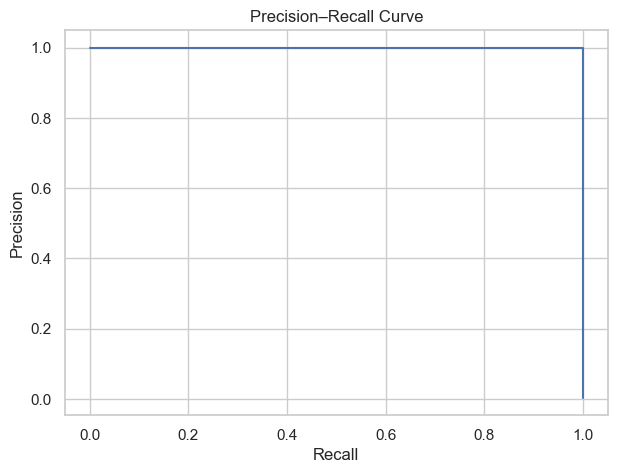

In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, y_prob_rf
)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


### Threshold Tuning

In [15]:
custom_threshold = 0.3

y_pred_custom = (y_prob_rf >= custom_threshold).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1268270
           1       1.00      1.00      1.00      4254

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



### ROC Curve & AUC

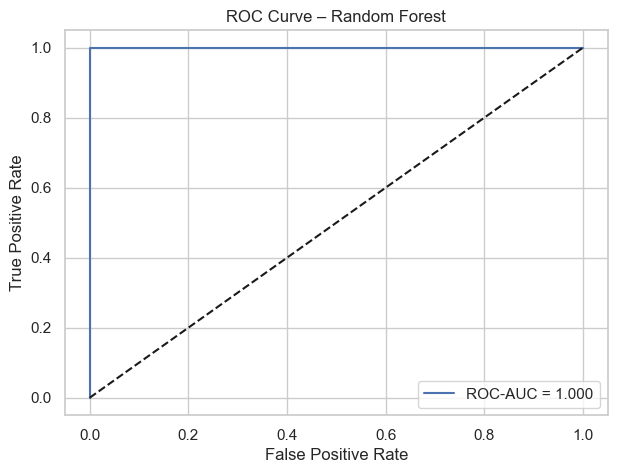

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob_rf):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()


**The model provides strong discrimination between fraudulent and legitimate transactions, as indicated by a high ROC-AUC. By adjusting the decision threshold, the system can be tuned to prioritize fraud recall while maintaining acceptable precision, making it practical for real-world deployment.**

### MODEL EXPLAINABILITY

**Model explainability is essential in fraud detection to ensure transparency, trust, and regulatory compliance.**

### Global Explainability: Feature Importance

In [17]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


amount_balance_ratio    0.286359
orig_balance_diff       0.223397
newbalanceOrig          0.110191
oldbalanceOrg           0.089484
zero_balance_after      0.082924
amount                  0.062618
type_TRANSFER           0.038629
dest_balance_diff       0.029507
type_PAYMENT            0.027699
newbalanceDest          0.015998
dtype: float64

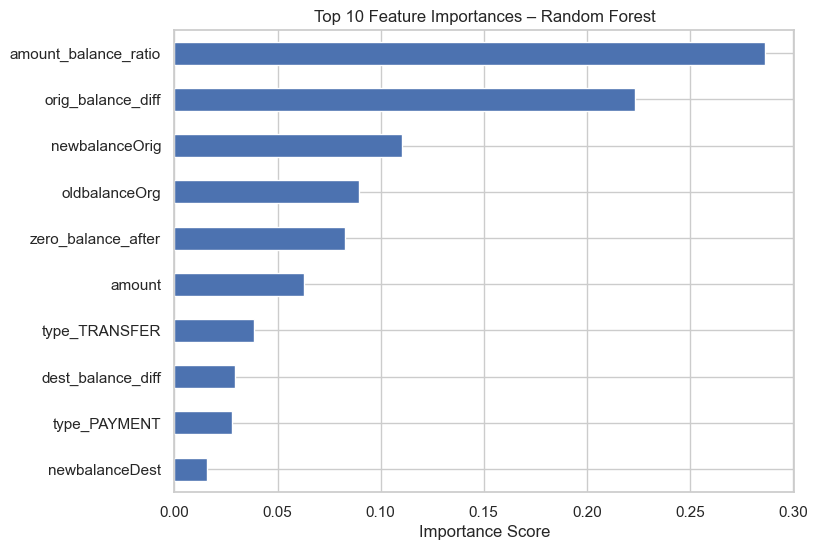

In [18]:
plt.figure(figsize=(8,6))
feature_importance.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.show()


**The model primarily relies on behavioral features such as abnormal balance changes, transaction type, and amount-to-balance ratios to identify fraud.**

### Local Explainability: Why THIS Transaction Was Flagged

In [19]:
fraud_cases = X_test[y_test == 1]
fraud_cases.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,amount_balance_ratio,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_diff,dest_balance_diff,zero_balance_after,large_amount_flag
5095274,355,3592596.97,3592596.97,0.0,0.00,0.00,1.000000,False,False,False,True,3592596.97,0.00,1,1
5095275,355,3592596.97,3592596.97,0.0,1512703.69,5105300.66,1.000000,True,False,False,False,3592596.97,3592596.97,1,1
5101687,355,5338162.80,5338162.80,0.0,0.00,0.00,1.000000,False,False,False,True,5338162.80,0.00,1,1
5101688,355,5338162.80,5338162.80,0.0,181895.58,5520058.37,1.000000,True,False,False,False,5338162.80,5338162.79,1,1
5121824,356,357226.80,357226.80,0.0,0.00,357226.80,0.999997,True,False,False,False,357226.80,357226.80,1,0


In [20]:
sample_idx = fraud_cases.index[0]
sample_transaction = X_test.loc[sample_idx:sample_idx]
sample_transaction


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,amount_balance_ratio,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_balance_diff,dest_balance_diff,zero_balance_after,large_amount_flag
5095274,355,3592596.97,3592596.97,0.0,0.0,0.0,1.0,False,False,False,True,3592596.97,0.0,1,1


In [21]:
rf.predict(sample_transaction)
rf.predict_proba(sample_transaction)


array([[0.015, 0.985]])

In [22]:
sample_transaction.T


,5095274
step,355
amount,3592596.97
oldbalanceOrg,3592596.97
newbalanceOrig,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
amount_balance_ratio,1.0
type_CASH_OUT,False
type_DEBIT,False
type_PAYMENT,False


**This transaction was flagged as fraudulent because it involved a high-value transfer relative to the account’s available balance, resulted in the sender’s balance dropping to zero, and occurred through a transaction type historically associated with fraud (TRANSFER). These combined behavioral signals strongly indicate account-draining fraud.**